In [22]:
!pip -q install transformers accelerate datasets


Chargement données

In [23]:
import json
import pandas as pd

FILE_10K = "/content/reviews_10000.jsonl"

rows = []
with open(FILE_10K, "r", encoding="utf-8") as f:
    for line in f:
        obj = json.loads(line)
        rows.append({
            "review_id": obj.get("review_id"),
            "stars": obj.get("stars"),
            "text": obj.get("text")
        })

df = pd.DataFrame(rows).dropna(subset=["text", "stars"]).reset_index(drop=True)
print("Shape:", df.shape)
df.head(3)


Shape: (10000, 3)


,review_id,stars,text
0,J5Q1gH4ACCj6CtQG7Yom7g,2,Went for lunch and found that my burger was me...
1,HlXP79ecTquSVXmjM10QxQ,5,I needed a new tires for my wife's car. They h...
2,JBBULrjyGx6vHto2osk_CQ,5,Jim Woltman who works at Goleta Honda is 5 sta...


Chargement modèle RoBERTa

In [24]:
from transformers import pipeline

# Modèle spécialisé sentiment
sentiment_model = pipeline(
    "sentiment-analysis",
    model="cardiffnlp/twitter-roberta-base-sentiment-latest"
)

print("Modèle chargé")


config.json:   0%|          | 0.00/929 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/501M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/501M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

RobertaForSequenceClassification LOAD REPORT from: cardiffnlp/twitter-roberta-base-sentiment-latest
Key                             | Status     |  | 
--------------------------------+------------+--+-
roberta.pooler.dense.bias       | UNEXPECTED |  | 
roberta.pooler.dense.weight     | UNEXPECTED |  | 
roberta.embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

Modèle chargé


Fonction polarité

In [25]:
def predict_sentiment_specialized(text):
    result = sentiment_model(text)[0]

    label = result["label"].lower()


    if "positive" in label:
        return "positive"
    if "negative" in label:
        return "negative"
    if "neutral" in label:
        return "neutral"

    return "unknown"


Conversion polarité → note

In [26]:
# test_text = "I don't like this restaurant"
# test_text = "I like this restaurant"
#test_text = "I don't like this restaurant"
test_text = "the food is good but i was sick after"



print("Texte :", test_text)
print("Prédiction :", predict_sentiment_specialized(test_text))


Texte : the food is good but i was sick after
Prédiction : negative


In [27]:
def sentiment_to_rating(sentiment):
    if sentiment == "negative":
        return 1
    if sentiment == "neutral":
        return 3
    if sentiment == "positive":
        return 5
    return None


In [28]:
#text = "The food was great but the service was slow"
#text = "The food was not great and the service was slow"
text = "The food  can be better"



sentiment = predict_sentiment_specialized(text)
rating = sentiment_to_rating(sentiment)

print("Texte :", text)
print("Polarité prédite :", sentiment)
print("Note estimée :", rating)


Texte : The food  can be better
Polarité prédite : neutral
Note estimée : 3


In [29]:
import random
from tqdm import tqdm
import pandas as pd

pd.set_option("display.max_colwidth", None)

# 100 avis aléatoires
sample_100 = df.sample(100, random_state=42).reset_index(drop=True)

results = []

for _, row in tqdm(sample_100.iterrows(), total=100):
    text = str(row["text"])

    #Polarité prédite
    result = sentiment_model(
        text,
        truncation=True,
        max_length=512
    )[0]

    polarity = result["label"].lower()

    # Conversion polarité
    if polarity == "negative":
        rating = 1
    elif polarity == "neutral":
        rating = 3
    elif polarity == "positive":
        rating = 5
    else:
        rating = None

    results.append({
        "true_stars": row["stars"],
        "pred_rating": rating,
        "pred_polarity": polarity,
        "text": text
    })

results_df = pd.DataFrame(results)

# Afficher 50 premières lignes
results_df.head(50)



100%|██████████| 100/100 [01:45<00:00,  1.05s/it]


,true_stars,pred_rating,pred_polarity,text
0,5,1,negative,Skip the starbucks. This is real stuff like that is high end. Go explore your taste buds.
1,2,1,negative,I placed an order that was confirmed for delivery only for it to never arrive. I called them 3-4 times before someone finally answered and it took them a week to give me a refund for the flowers my friend never received. Really disappointing.
2,5,5,positive,"They have cleaned our house 3 consecutive times over 6 weeks. The most recent visit was the best. I was late to work bc the babysitter didn't show up (our kids ages are 2, 4, 6). I left breakfast dishes on the counter, pajamas lying on the floor, etc as I ran out of the house. \n\nWhen I returned that evening, they had taken care of all the messes I had made in the rush. For a morning to be so crazy, it was an awesome evening with a perfectly clean house."
3,4,5,positive,Tiny place but delicious food. If you're willing to wait for something really tasty and comfortable in an informal environment I'd definitely suggest going here. We met up for an early lunch and spent awhile chatting and catching up while we ate and it was great.
4,5,5,positive,This place is amazing!!!!! Decor is super cool! Bartenders are great. The baguettes are to die for! As soon as we arrived we were given a quick tour (which was appreciated). The vibe overall was just So fun! We can't go back for another girls night.
5,5,5,positive,"Nicole and Ethan are awesome leasing/management personnel. Perfect location. If you can't handle elevators, noise, APARTMENT LIVING..... move into a house, leave your bias reviews in your pocket. Otherwise this building has a ton of social and friendly people. Lots of dogs in this area with a park right outside. Pool deck on the roof with a social crowd. Great place for young professionals."
6,4,5,positive,"It was dinner date night with my darling and we picked LT. It's been around for quite a while now but it was our first visit. Of course, I reviewed the menu online and read a few reviews to get a feel of things. \n\nWe ordered two apps that were specials for the evening. I wanted to try the marrow bone because I've only had it roasted, never had ""smoked"" marrow. Since we were both getting a meat entree we decided to go lite for apps. We had the grilled shrimp on a salad of watermelon, cucumber, peach, blueberries and arugla; and an heirloom tomato salad. Both were very good and just right for an app. For entrees my wife had the rack of lamb and I had the pork loin. Again both were very good (so happy to find a restaurant that can cook pork correctly!). If there was a quibble it would be the lamb little was more rare than medium rare but not enough to send back. More a personal preference. \n\nDesert was the bananas foster bread pudding...fantastic. \n\nAll in all, good service and a very good dinner. We'll visit again for sure."
7,5,5,positive,Great for semi private event. Carrie was extremely responsive and professional and made sure we were taken care of. Highly recommend
8,5,5,positive,"It was time to have a genuine Honduran restaurant with quality modern cuisine in New Orleans. The food and service were great, price is reasonable for the concept and location. I ordered the baleada, horchata and a latte, delicious! We will definitely be back! Awesome restaurant!"
9,2,1,negative,Had a Tucson scramble. It was good but the potatoes that came on the side were very old and very cold. They never bothered to check on me and offered no replacement or discount!


In [30]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

#Convertir les vraies notes en polarité binaire
def stars_to_polarity(stars):
    if stars <= 2:
        return "negative"
    elif stars >= 4:
        return "positive"
    else:
        return "neutral"

results_df["true_polarity"] = results_df["true_stars"].apply(stars_to_polarity)

# Supprimer les neutres pour comparaison binaire propre
binary_df = results_df[results_df["true_polarity"] != "neutral"]

# Accuracy Polarité
acc_polarity = accuracy_score(
    binary_df["true_polarity"],
    binary_df["pred_polarity"]
)

print("Accuracy polarité :", round(acc_polarity, 3))

print("\nClassification report (polarité) :\n")
print(classification_report(
    binary_df["true_polarity"],
    binary_df["pred_polarity"]
))



Accuracy polarité : 0.914

Classification report (polarité) :

              precision    recall  f1-score   support

    negative       0.96      0.82      0.88        28
     neutral       0.00      0.00      0.00         0
    positive       0.97      0.95      0.96        65

    accuracy                           0.91        93
   macro avg       0.64      0.59      0.62        93
weighted avg       0.97      0.91      0.94        93



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [31]:
from sklearn.metrics import classification_report, accuracy_score

# Calcul de l'accuracy globale pour les notes
acc_rating = accuracy_score(
    results_df["true_stars"],
    results_df["pred_rating"]
)

print(f"Accuracy globale des notes : {round(acc_rating, 3)}")
print("\nClassification report détaillé par nombre d'étoiles :")
print("-" * 60)

# L'utilisation de classification_report sur les colonnes de notes
# donnera la précision, le recall et le f1-score pour 1, 2, 3, 4 et 5.
print(classification_report(
    results_df["true_stars"],
    results_df["pred_rating"],
    digits=3
))

Accuracy globale des notes : 0.61

Classification report détaillé par nombre d'étoiles :
------------------------------------------------------------
              precision    recall  f1-score   support

           1      0.731     0.950     0.826        20
           2      0.000     0.000     0.000         8
           3      0.167     0.143     0.154         7
           4      0.000     0.000     0.000        22
           5      0.603     0.953     0.739        43

    accuracy                          0.610       100
   macro avg      0.300     0.409     0.344       100
weighted avg      0.417     0.610     0.494       100



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


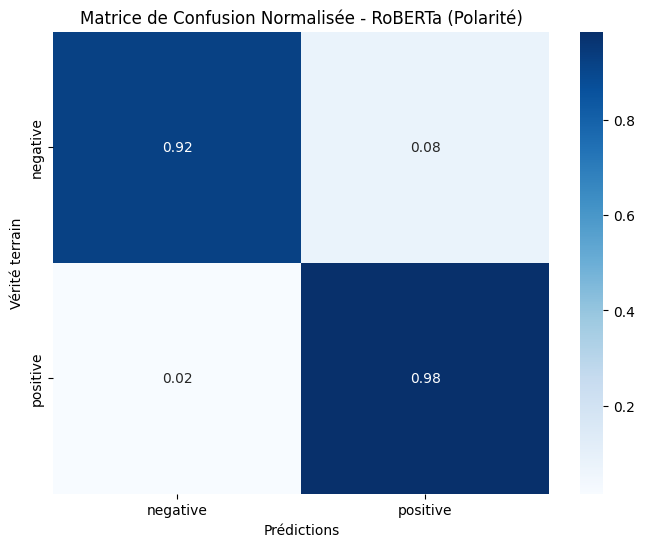

In [32]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# On enlève les neutres
binary_df = results_df[results_df["true_polarity"] != "neutral"]

y_true = binary_df["true_polarity"]
y_pred = binary_df["pred_polarity"]

target_names = ["negative", "positive"]

cm = confusion_matrix(y_true, y_pred, labels=target_names)

cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(8,6))
sns.heatmap(
    cm_normalized,
    annot=True,
    fmt='.2f',
    cmap='Blues',
    xticklabels=target_names,
    yticklabels=target_names
)

plt.title('Matrice de Confusion Normalisée - RoBERTa (Polarité)')
plt.xlabel('Prédictions')
plt.ylabel('Vérité terrain')
plt.show()


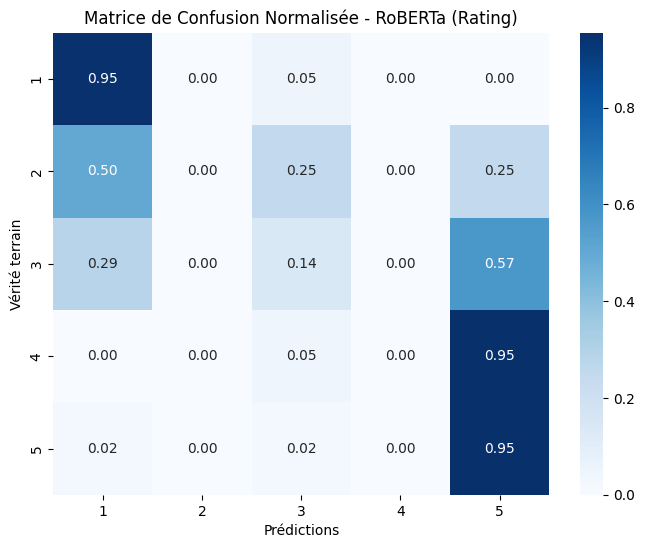

In [33]:
y_true = results_df["true_stars"].astype(int)
y_pred = results_df["pred_rating"].astype(int)

target_names = [1,2,3,4,5]

cm = confusion_matrix(y_true, y_pred, labels=target_names)

cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(8,6))
sns.heatmap(
    cm_normalized,
    annot=True,
    fmt='.2f',
    cmap='Blues',
    xticklabels=target_names,
    yticklabels=target_names
)

plt.title('Matrice de Confusion Normalisée - RoBERTa (Rating)')
plt.xlabel('Prédictions')
plt.ylabel('Vérité terrain')
plt.show()
